# Time to get your hands dirty! The transient Universe

### Task 
Let's go back to our previous example on the astrophysical transient.
8. Fit the same model from before with the same priors, but this time use nested sampling.
$$
y = b, \quad \text{for } t < t_0
$$

$$
y = b + A \exp[-\alpha (t - t_0)], \quad \text{for } t \geq t_0
$$

Be careful with how you transform your parameter space into a unit hypercube for the nested sampling priors (I used ppf from scipy.stats.uniform, but there are other ways to do it)
An appropriate check on whether you have done things correctly is that the posterior samples you get from the burst analysis here should give an equivalent corner plot to the MCMC you did earlier.

9. Another possible model that may explain the data is a Gaussian profile described by:
$$
y = b + A \exp[-(t - t_0)^2/2\sigma_g^2], \quad \text{for } t \geq t_0
$$
Fit this model usign nested sampling and reasonable priors (this time is up to you to decide...)

10. Unlike MCMCs, nested sampling provides the Bayesian evidence. Compute the Bayesian evidence for this Gaussian model, and for the original burst model. Which model is the favored description of the data? Express this in terms of the Jeffrey's scale.

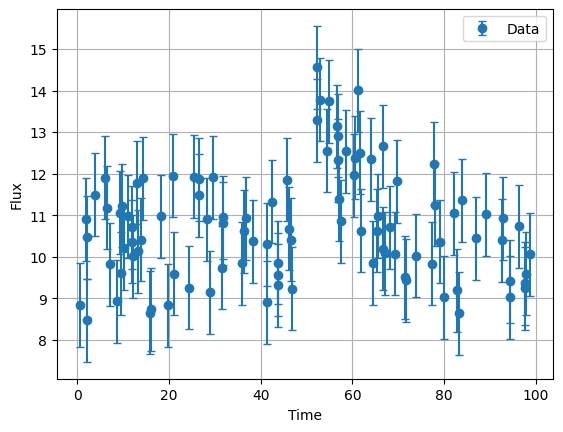

In [1]:
import numpy as np
from matplotlib import pyplot as plt

data = np.load("transient.npy")

time_data, flux, err = data[:,0], data[:,1], data[:,2]

plt.errorbar(time_data, flux, yerr=err, fmt='o', label='Data', capsize=3)
plt.xlabel("Time")
plt.ylabel("Flux")
plt.legend()
plt.grid()
plt.show()


/tmp/ipykernel_35605/1245363544.py:8: RuntimeWarning: overflow encountered in exp
  C + A * np.exp(- alpha *(t - t0)))          # else , hp function
/tmp/ipykernel_35605/1245363544.py:8: RuntimeWarning: overflow encountered in multiply
  C + A * np.exp(- alpha *(t - t0)))          # else , hp function
1763it [00:02, 443.65it/s, bound: 0 | nc: 26 | ncall: 17421 | eff(%): 10.120 | loglstar:   -inf < -276.344 <    inf | logz: -284.618 +/-  0.121 | dlogz: 113.913 >  0.509]   /tmp/ipykernel_35605/1245363544.py:8: RuntimeWarning: overflow encountered in exp
  C + A * np.exp(- alpha *(t - t0)))          # else , hp function
1814it [00:02, 360.81it/s, bound: 1 | nc: 2 | ncall: 17885 | eff(%): 10.143 | loglstar:   -inf < -261.292 <    inf | logz: -269.588 +/-  0.121 | dlogz: 98.765 >  0.509]  /tmp/ipykernel_35605/1245363544.py:8: RuntimeWarning: overflow encountered in multiply
  C + A * np.exp(- alpha *(t - t0)))          # else , hp function
1892it [00:02, 426.07it/s, bound: 1 | nc: 14 | ncal

(<Figure size 970x970 with 16 Axes>,
 array([[<Axes: title={'center': '$C$ = ${10.293}_{-0.240}^{+0.238}$'}>,
         <Axes: >, <Axes: >, <Axes: >],
        [<Axes: ylabel='$A$'>,
         <Axes: title={'center': '$A$ = ${5.343}_{-1.965}^{+4.226}$'}>,
         <Axes: >, <Axes: >],
        [<Axes: ylabel='$\\alpha$'>, <Axes: >,
         <Axes: title={'center': '$\\alpha$ = ${0.122}_{-0.042}^{+0.062}$'}>,
         <Axes: >],
        [<Axes: xlabel='$C$', ylabel='$t_0$'>, <Axes: xlabel='$A$'>,
         <Axes: xlabel='$\\alpha$'>,
         <Axes: title={'center': '$t_0$ = ${49.127}_{-2.150}^{+2.859}$'}, xlabel='$t_0$'>]],
       dtype=object))

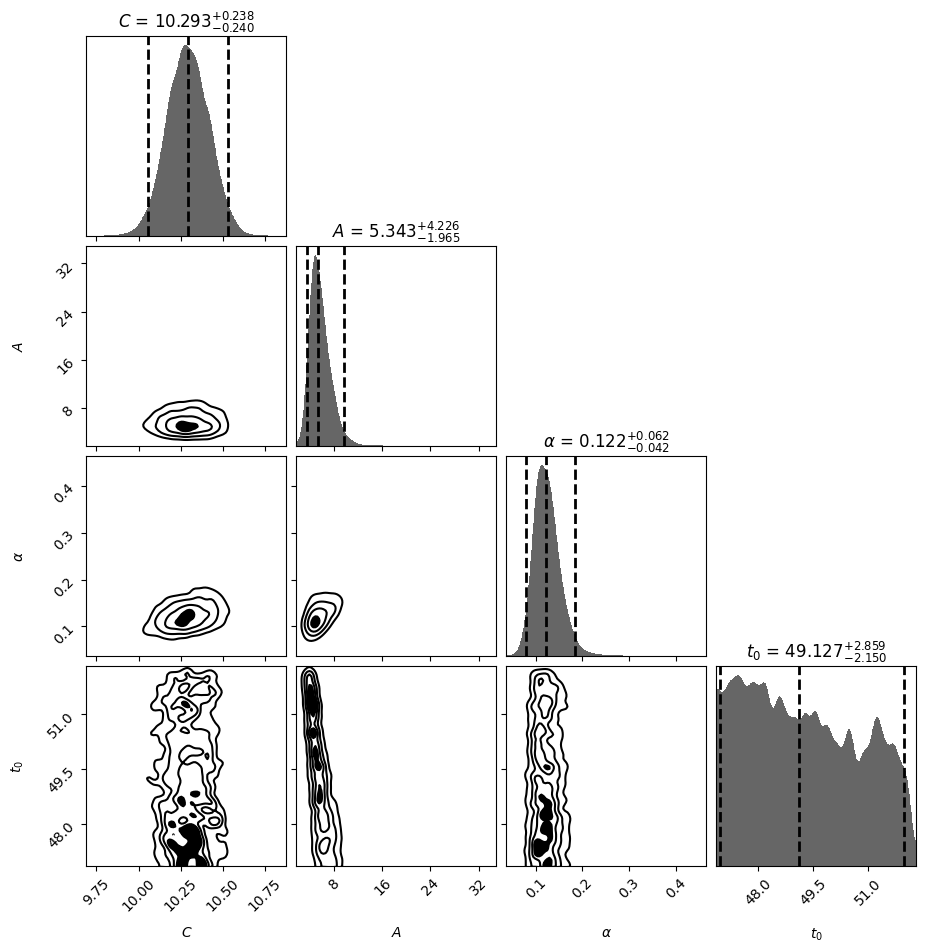

In [2]:
import dynesty
from dynesty import plotting as dyplot

def model (t, theta):
    C, A, alpha, t0 = theta
    return np.where(t < t0,                                     # for t < t0
                    C,                                          #costant
                    C + A * np.exp(- alpha *(t - t0)))          # else , hp function

def loglikelihood(theta):       #This time i'd like to try this in the log approach (see ex. before)
    model_flux = model(time_data, theta)
    chi2 = np.sum(((flux - model_flux) / err) ** 2)
    logL = -0.5 * chi2 - np.sum(np.log(np.sqrt(2 * np.pi) * err))
    return logL

def prior(u):
    C = 0 + 50 * u[0]                          # Uniform(0, 50)
    A = 0 + 50 * u[1]                          # Uniform(0, 50)
    alpha = np.exp(-5 + 10 * u[2])             # Log-uniform in [e^-5, e^5]
    t0 = 0 + 100 * u[3]                        # Uniform(0, 100)
    return [C, A, alpha, t0]


ndim = 4  #number of parameters

sampler = dynesty.NestedSampler(loglikelihood, prior, ndim)
sampler.run_nested()    
sresult = sampler.results
labels = [r"$C$", r"$A$", r"$\alpha$", r"$t_0$"]
dyplot.cornerplot(sresult, show_titles=True, labels=labels, title_fmt=".3f")

Thinning and burn in period do not exist in this approach, simply because it's a complete different method instead of MCMC

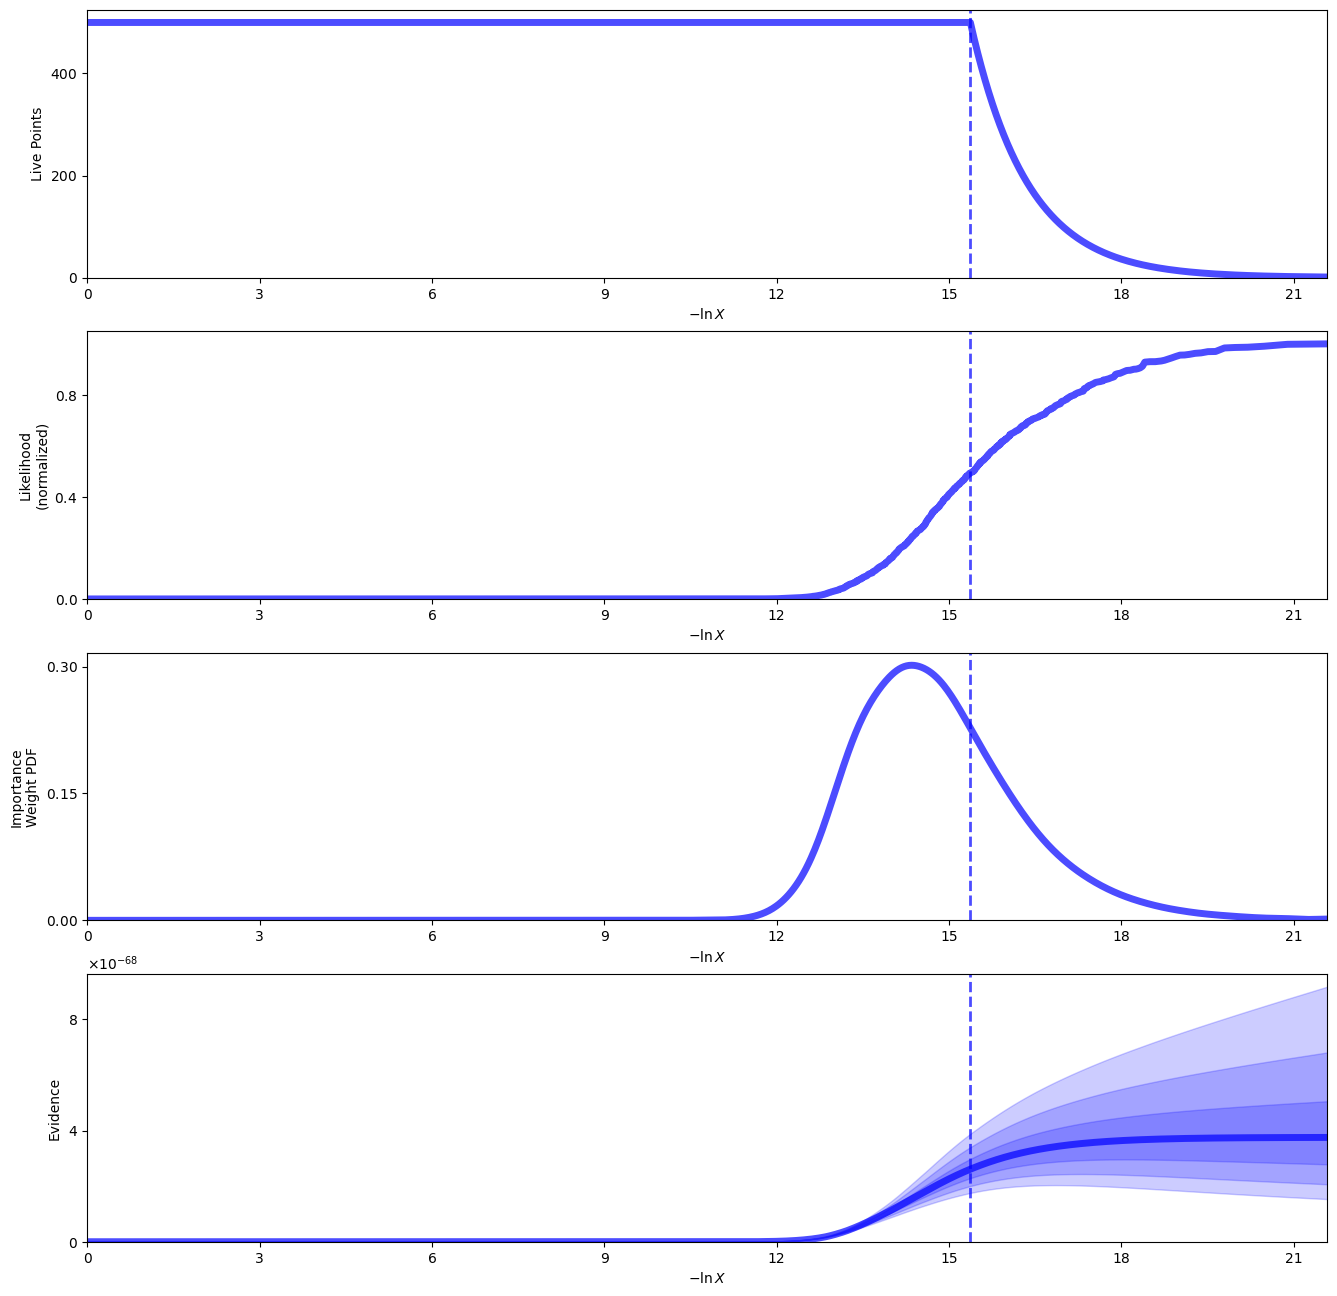

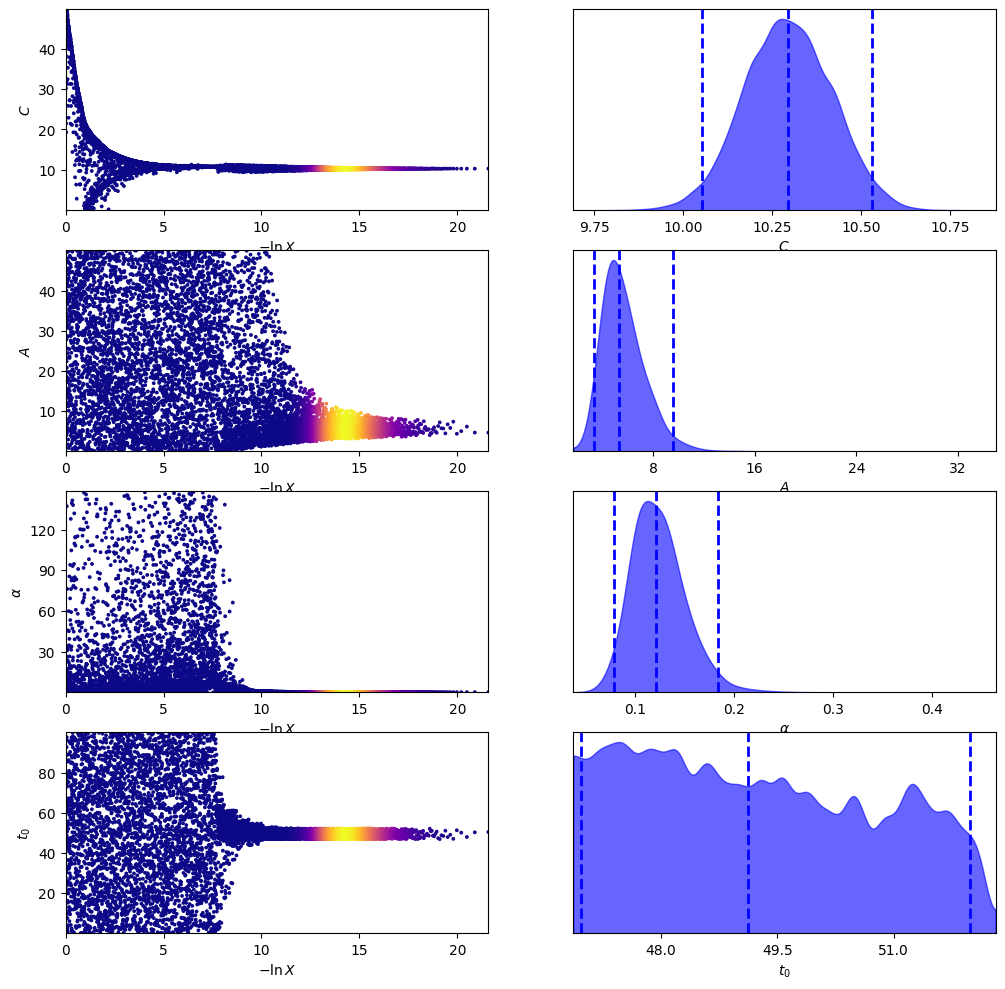

In [3]:
rfig, raxes = dyplot.runplot(sresult)
tfig, taxes = dyplot.traceplot(sresult , labels=labels)

### **About the plot above**
1. on the  first y-axis, we have the number of point that the algorithm keep to sample the space. the **first one** has a costant number then ther's a point (treshold) in wich the algorithm understand where concentrate them, so they fall
2. the **second** has the likelihood on the y-axis, over the treshold point it grows significantly
3. useless
4. on the y-axis has a measurment of the total probability of the model, the spread exprime the correspondent spread

5. 6. 7. 8. Are just trace plot



=== Parameter comparison (with ±1σ uncertainties) ===
Dynesty (MAP):  C = 10.298 ± 0.592
                A = 4.632 ± 15.205
            alpha = 0.117 ± 11.613
               t0 = 50.420 ± 16.838

curve_fit:  C = 10.298 ± 0.126
            A = 3.707 ± 0.602
        alpha = 0.117 ± 0.031
           t0 = 52.185 ± 0.000


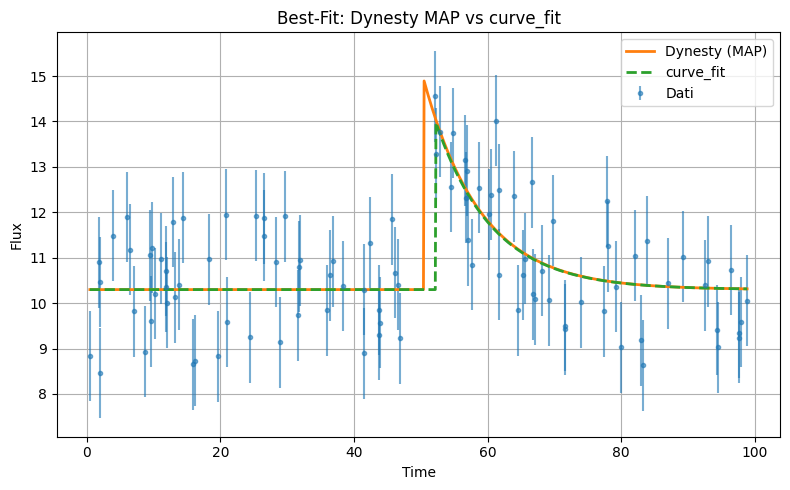

In [ ]:
from scipy.optimize import curve_fit

def model_curve_fit(t, C, A, alpha, t0):    #just a problem with the array
    return np.where(t < t0,
                    C,
                    C + A * np.exp(-alpha * (t - t0)))

# initial values for fitting
C0 = np.median(flux)
A0 = np.max(flux) - C0
alpha0 = 0.1
t0_init = time_data[np.argmax(flux)]


# === Dynesty:  MAP Max At Posteriori ===
best_idx = np.argmax(sresult.logl)  #contains the log-likelihood values for each sampled point,
pars_map = sresult.samples[best_idx]    #holds the corresponding parameter vectors.
C_map, A_map, alpha_map, t0_map = pars_map

q16, q84 = np.percentile(sresult.samples, [16, 84], axis=0)
errors_dynesty = 0.5 * (q84 - q16)
err_C_map, err_A_map, err_alpha_map, err_t0_map = errors_dynesty # I know ... I should integrate from the map up to a 64% of the values of the dataset ... that's an approximation

# === curve_fit ===
popt, pcov = curve_fit(model_curve_fit, time_data, flux, sigma=err, p0=[C0, A0, alpha0, t0_init])
perr = np.sqrt(np.diag(pcov))  # 1σ uncertainties from covariance
C_cf, A_cf, alpha_cf, t0_cf = popt
err_C_cf, err_A_cf, err_alpha_cf, err_t0_cf = perr

# chi-squared using the output parameters from curve_fit
residuals = flux - model_curve_fit(time_data, *popt)
chi_squared = np.sum((residuals / err) ** 2)

# === Comparison ===
print("\n=== Parameter comparison (with ±1σ uncertainties) ===")
print(f"Dynesty (MAP):  C = {C_map:.3f} ± {err_C_map:.3f}")
print(f"                A = {A_map:.3f} ± {err_A_map:.3f}")
print(f"            alpha = {alpha_map:.3f} ± {err_alpha_map:.3f}")
print(f"               t0 = {t0_map:.3f} ± {err_t0_map:.3f}")

print(f"\ncurve_fit:  C = {C_cf:.3f} ± {err_C_cf:.3f}")
print(f"            A = {A_cf:.3f} ± {err_A_cf:.3f}")
print(f"        alpha = {alpha_cf:.3f} ± {err_alpha_cf:.3f}")
print(f"           t0 = {t0_cf:.3f} ± {err_t0_cf:.3f}")

# === Plot ===
t_fit = np.linspace(time_data.min(), time_data.max(), 1000)
flux_map = model(t_fit, pars_map)
flux_cf  = model(t_fit, popt)

plt.figure(figsize=(8, 5))
plt.errorbar(time_data, flux, yerr=err, fmt='.', label='Dati', alpha=0.6)
plt.plot(t_fit, flux_map, '-', lw=2, label='Dynesty (MAP)', c='C1')
plt.plot(t_fit, flux_cf, '--', lw=2, label='curve_fit', c='C2')
plt.xlabel("Time")
plt.ylabel("Flux")
plt.title("Best-Fit: Dynesty MAP vs curve_fit")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#SEE THE EXERCISE BEFORE FOR A BETTER EXPLAINATION ON FIT AVER BAYESIAN ANALYSIS

6483it [00:12, 531.70it/s, +500 | bound: 28 | nc: 1 | ncall: 39305 | eff(%): 17.995 | loglstar:   -inf < -144.381 <    inf | logz: -156.614 +/-  0.156 | dlogz:  0.001 >  0.509]


(<Figure size 970x970 with 16 Axes>,
 array([[<Axes: title={'center': '$C$ = ${10.320}_{-0.244}^{+0.232}$'}>,
         <Axes: >, <Axes: >, <Axes: >],
        [<Axes: ylabel='$A$'>,
         <Axes: title={'center': '$A$ = ${2.720}_{-0.723}^{+0.817}$'}>,
         <Axes: >, <Axes: >],
        [<Axes: ylabel='$\\sigma$'>, <Axes: >,
         <Axes: title={'center': '$\\sigma$ = ${5.367}_{-1.535}^{+1.862}$'}>,
         <Axes: >],
        [<Axes: xlabel='$C$', ylabel='$t_0$'>, <Axes: xlabel='$A$'>,
         <Axes: xlabel='$\\sigma$'>,
         <Axes: title={'center': '$t_0$ = ${55.425}_{-1.946}^{+2.055}$'}, xlabel='$t_0$'>]],
       dtype=object))

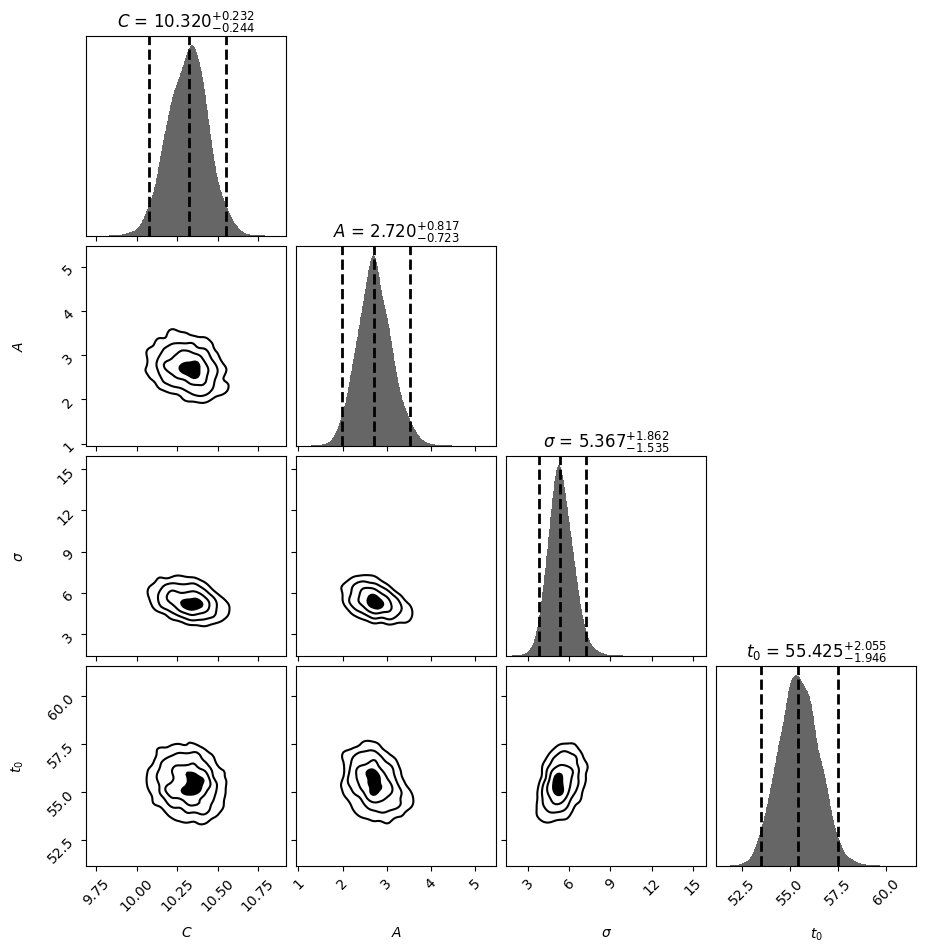

In [5]:
def model2(t, theta):
    C, A, sigma, t0 = theta
    return C + A * np.exp(-(t - t0)**2 / (2 * sigma**2))

def prior_transform2(u):

    ymin = np.min(flux)
    ymax = np.max(flux)
    C = ymin + (ymax - ymin) * u[0]            # Uniform between min and max of the flux
    
    A = 0 + (ymax-ymin) * u[1]                 # Uniform between the "base" and the peak
    
    sigma = 0 + 100*u[2]                        # uniform in 0 - 100

    T = time_data[np.argmax(flux)]
    ymin = T - 30
    ymax = T + 30
    t0 = ymin + (ymax - ymin) * u[3]                # Uniform between T-30 and T + 30

    return [C, A, sigma, t0]

def loglikelihood2(theta):
    C, A, sigma, t0 = theta
    model_flux = model2(time_data, theta)
    chi2 = np.sum(((flux - model_flux) / err) ** 2)
    logL = -0.5 * chi2 - np.sum(np.log(np.sqrt(2 * np.pi) * err))
    return logL

ndim = 4

sampler = dynesty.NestedSampler(loglikelihood2, prior_transform2 , ndim)
sampler.run_nested()
sresult2 = sampler.results
labels = [r"$C$", r"$A$", r"$\sigma$", r"$t_0$"]
dyplot.cornerplot(sresult2, show_titles=True, labels=labels, title_fmt=".3f")


mediana della distribuzione marginalizzata

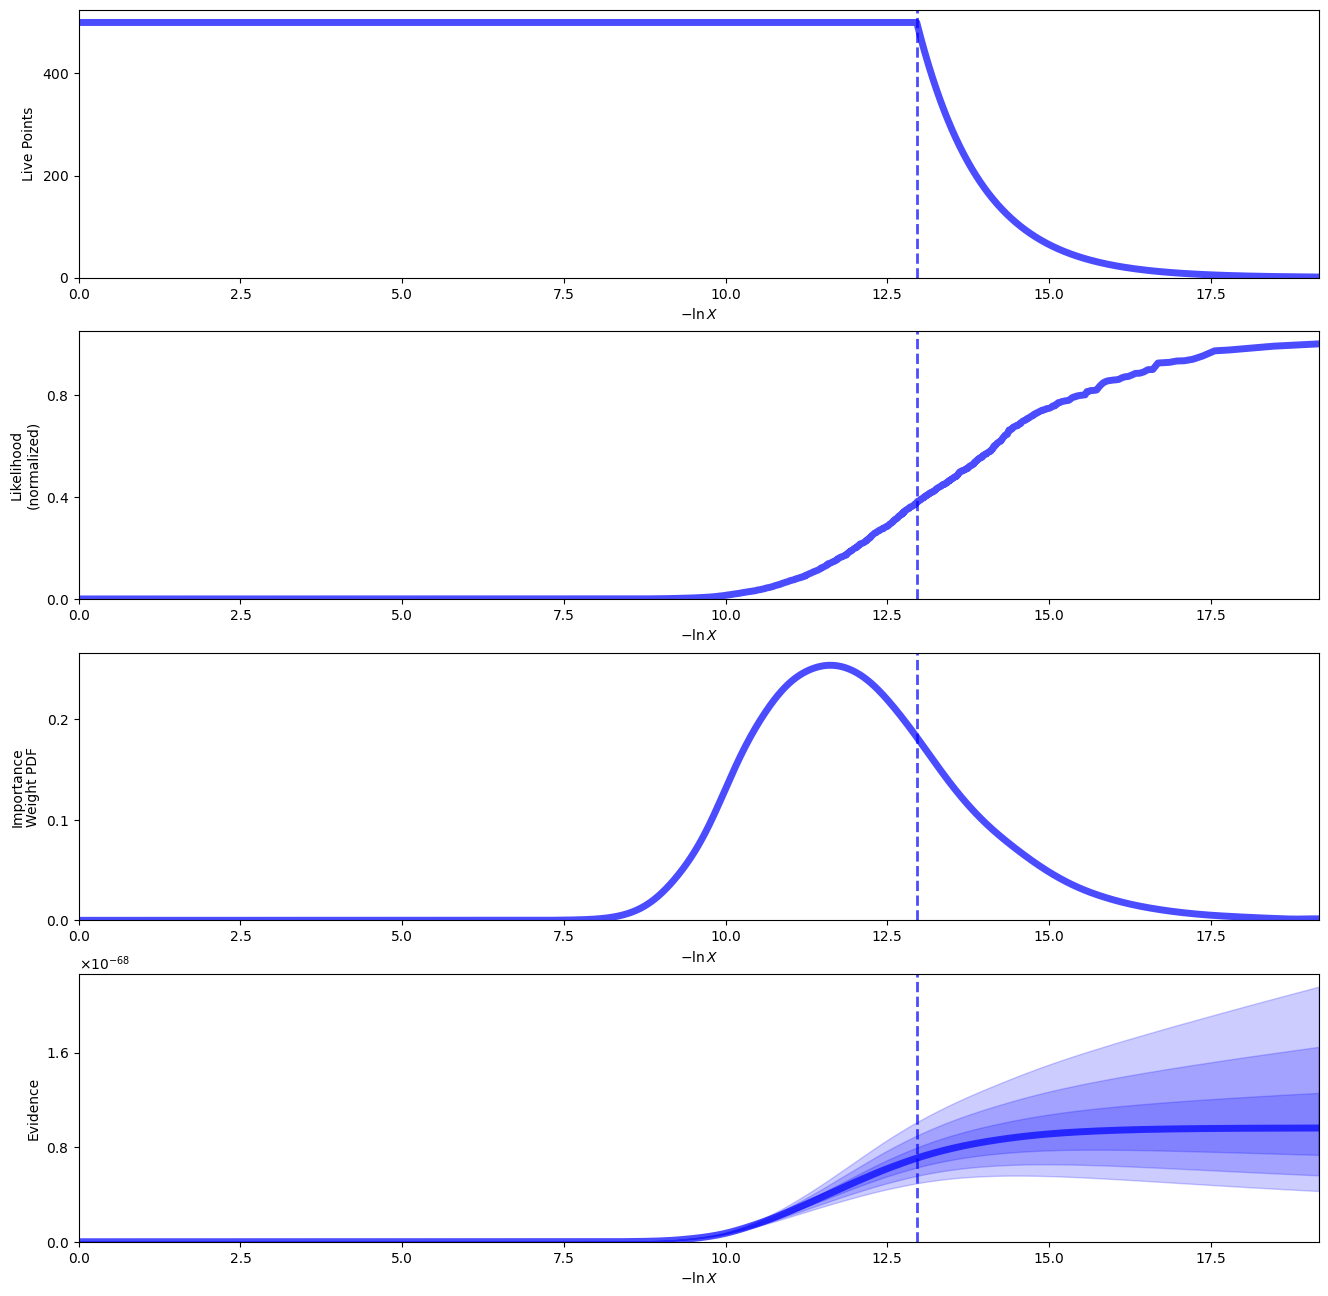

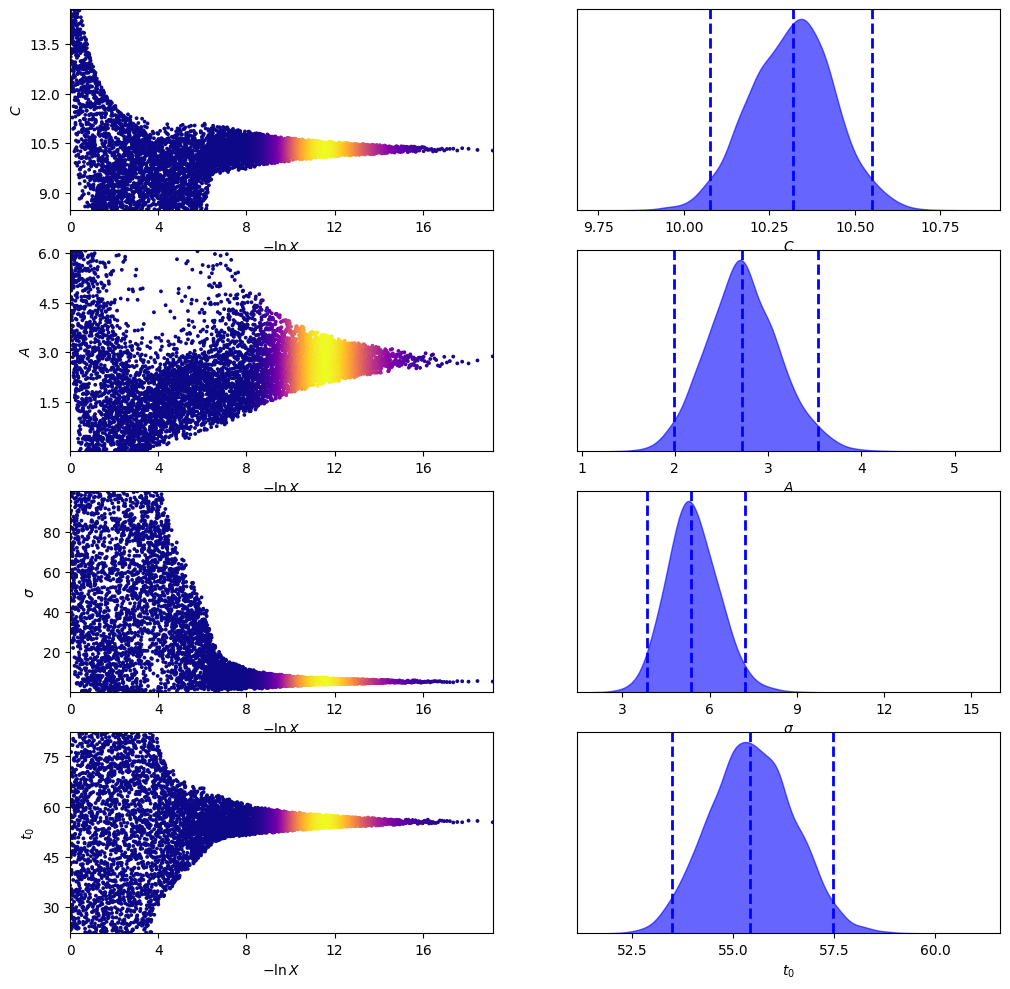

In [6]:
rfig, raxes = dyplot.runplot(sresult2)
tfig, taxes = dyplot.traceplot(sresult2 , labels=labels)


=== Parameter comparison (with ±1σ uncertainties) ===
Dynesty (MAP):  C = 10.272 ± 0.592
                A = 2.876 ± 15.205
            alpha = 0.117 ± 11.613
               t0 = 55.348 ± 16.838

curve_fit:  C = 10.307 ± 0.128
            A = 2.751 ± 0.371
        alpha = 0.117 ± 0.948
           t0 = 55.472 ± 0.992


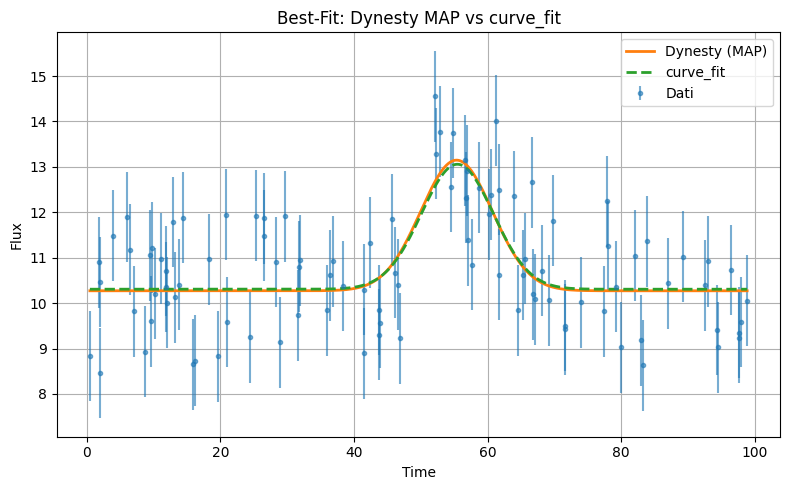

In [7]:
from scipy.optimize import curve_fit

def model_curve_fit2(t, C, A, sigma ,t0):
        return C + A * np.exp(-(t - t0)**2 / (2 * sigma**2))

# initial values for fitting
C0 = np.median(flux)
A0 = np.max(flux) - C0
sigma0 = 5
t0_init = time_data[np.argmax(flux)]


# === Dynesty: MAP : Max At Posteriori ===
best_idx = np.argmax(sresult2.logl)
pars_map = sresult2.samples[best_idx]
C_map, A_map, sigma_map, t0_map = pars_map

q16, q84 = np.percentile(sresult.samples, [16, 84], axis=0)
errors_dynesty = 0.5 * (q84 - q16)
err_C_map, err_A_map, err_alpha_map, err_t0_map = errors_dynesty

# === curve_fit ===
popt, pcov = curve_fit(model_curve_fit2, time_data, flux, sigma=err, p0=[C0, A0, sigma0, t0_init])
C_cf, A_cf, sigma_cf, t0_cf = popt
perr = np.sqrt(np.diag(pcov))  # 1σ uncertainties from covariance
err_C_cf, err_A_cf, err_alpha_cf, err_t0_cf = perr

# chi-squared using the output parameters from curve_fit
residuals = flux - model_curve_fit2(time_data, *popt)
chi_squared2 = np.sum((residuals / err) ** 2)

# === comparison ===
print("\n=== Parameter comparison (with ±1σ uncertainties) ===")
print(f"Dynesty (MAP):  C = {C_map:.3f} ± {err_C_map:.3f}")
print(f"                A = {A_map:.3f} ± {err_A_map:.3f}")
print(f"            alpha = {alpha_map:.3f} ± {err_alpha_map:.3f}")
print(f"               t0 = {t0_map:.3f} ± {err_t0_map:.3f}")

print(f"\ncurve_fit:  C = {C_cf:.3f} ± {err_C_cf:.3f}")
print(f"            A = {A_cf:.3f} ± {err_A_cf:.3f}")
print(f"        alpha = {alpha_cf:.3f} ± {err_alpha_cf:.3f}")
print(f"           t0 = {t0_cf:.3f} ± {err_t0_cf:.3f}")

# === Plot ===
t_fit = np.linspace(time_data.min(), time_data.max(), 1000)
flux_map = model2(t_fit, pars_map)
flux_cf  = model2(t_fit, popt)

plt.figure(figsize=(8, 5))
plt.errorbar(time_data, flux, yerr=err, fmt='.', label='Dati', alpha=0.6)
plt.plot(t_fit, flux_map, '-', lw=2, label='Dynesty (MAP)', c='C1')
plt.plot(t_fit, flux_cf, '--', lw=2, label='curve_fit', c='C2')
plt.xlabel("Time")
plt.ylabel("Flux")
plt.title("Best-Fit: Dynesty MAP vs curve_fit")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
#compute the ratio of the evidence
O = np.exp(sresult.logz[-1])/np.exp(sresult2.logz[-1])  #i's an array in witch each element rappresent the estimation of the log-evidence (log Z) 
#sresult.logz[-1] it's the last evaluation obtained at the end of the run of dynesy

print("The odds ratio between the two model is = ", O)

# Because of the two models has the same number of parameter, I can also compare the chi-squared values
print("First model chi-squared: ", chi_squared, "\nSecond model chi-squared: ", chi_squared2)

The odds ratio between the two model is =  3.8994013540051484
First model chi-squared:  97.54296592455576 
Second model chi-squared:  104.80127988395242


- The lower chi-squared is better, so Model 1 fits the data better.
- This odds factor means that Model 1 is ~3.1 times more probable than Model 2, given the data and priors. According to Jeffreys' scale: 1–3: barely worth mentioning